In [1]:
from data_prep import *
from PositionModel import *
from PlayerModel import *
from commons import *
import shap
from sklearn.ensemble import RandomForestRegressor

In [2]:
features = ['goals_avg5', 'xG_avg5', 'assists_fpl_avg5',
       'bonus_avg5', 'bps_avg5', 'clean_sheets_avg5', 'goals_conceded_avg5',
       'shots_avg5', 'xGBuildup_avg5', 'xGChain_avg5', 'yellow_cards_avg5',
       'red_cards_avg5', 'was_home']
rolling_columns = ['goals', 'xG', 'assists_fpl', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'shots', 'xGBuildup', 'xGChain', 'yellow_cards', 'red_cards']
to_predict = 'total_points'

In [3]:
# loading dataset
# previous_games = merged_understat_and_fpl(rolling_columns, True)
previous_games = load_dataset()

In [4]:
# splitting data
X_train = previous_games[features]
y_train = previous_games[to_predict]

In [5]:
for f in X_train.iloc[0]:
    print(type(f))

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


In [6]:
# general model fitting
general_model = RandomForestRegressor(random_state=42)
general_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [7]:
# getting next gameweek
next_gameweek = get_next_gameweek(previous_games, NEXT_GAMEWEEK, rolling_columns)

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
# removing NaNs
next_gameweek = next_gameweek.dropna(subset = features)

In [9]:
# predicting
pred_points = general_model.predict(next_gameweek[features])

In [10]:
pred_points

array([5.91, 7.73, 4.13, 5.65, 8.35, 2.31, 1.53, 3.2 , 1.39, 2.08, 4.09,
       1.07, 4.83, 6.23, 2.1 , 5.1 , 6.25, 4.68, 2.08, 1.68, 3.01, 3.63,
       3.7 , 6.66, 1.49, 2.02, 4.23, 1.64, 7.46, 1.41, 1.93, 6.91, 5.08,
       4.41, 4.03, 6.96, 2.1 , 7.5 , 2.61, 0.  , 0.88, 2.  , 2.59, 4.84,
       3.48, 4.56, 2.18, 3.19, 6.  , 9.14, 3.7 , 1.91, 4.13, 2.91, 0.99,
       6.39, 3.86, 6.83, 6.26, 5.97, 6.79, 1.84, 5.1 , 4.17, 1.9 , 4.37,
       3.73, 1.55, 2.26, 5.38])

In [11]:
predictions = next_gameweek
predictions.insert(1, 'pred_points', pred_points)
predictions = predictions.sort_values(by = 'pred_points', ascending = False)

In [12]:
predictions[['name', 'was_home', 'pred_points']].head(20)

,name,was_home,pred_points
29,Reece James,0,9.14
76,Harry Kane,1,8.35
79,Dejan Kulusevski,1,7.73
26,Dominic Solanke,1,7.50
33,Christian Nørgaard,0,7.46
46,William Saliba,0,6.96
12,Harvey Barnes,1,6.91
70,Kevin De Bruyne,0,6.83
61,Ilkay Gündogan,0,6.79
69,Joe Ayodele-Aribo,0,6.66


In [13]:
# shap
explainer = shap.Explainer(general_model, X_train)
shap_values = explainer(X_train, check_additivity=False)

100%|===================| 8524/8537 [06:24<00:00]        

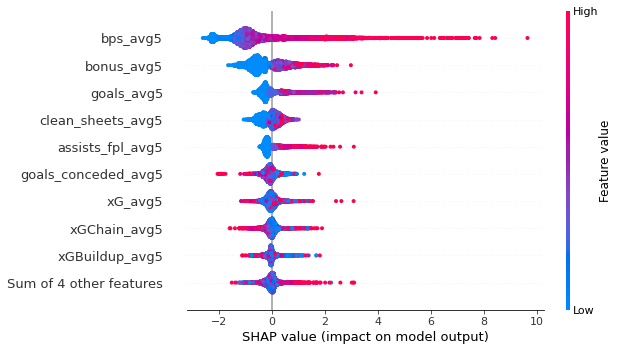

In [14]:
# feature influence
shap.plots.beeswarm(shap_values)

In [15]:
X_train.shape

(8537, 13)